## Loading Modules, Data and methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
# SVD

def power_iteration(A, num_iterations):
    """
    power iterations to find out 1 eigenvector of given matrix
    """
    b = np.random.rand(A.shape[1])

    for _ in range(num_iterations):
        Ab = np.dot(A, b)
        norm = np.linalg.norm(Ab)
        b = Ab / norm

    return b

def svd(A, num_iterations=1000, tol=1e-8):
    """
    return SVD of matrix A, S will be of (r,r) dimensions where r is rank of matrix A
    equivalent to numpy's np.linalg.svd(A, full_natrices=False) with tolerance for singular values
    """
    ATA = np.dot(A.T, A)

    V = []
    S = []

    # for reproducibility of code results
    np.random.seed(42)

    # finding right singular vectors
    for _ in tqdm(range(min(ATA.shape)), desc='Performing decomposition'):
        eigenvector = power_iteration(ATA, num_iterations)
        eigenvalue = np.dot(np.dot(eigenvector, ATA), eigenvector)

        if eigenvalue < tol:
            break

        eigenvector /= np.linalg.norm(eigenvector)

        V.append(eigenvector)
        S.append(eigenvalue)

        # reduce lambda * vT v from the eigendecomposition of AtA
        ATA = ATA - eigenvalue * np.outer(eigenvector, eigenvector)

    if not S:
        raise ValueError('Matrix has rank 0')

    S = np.sqrt(S)

    # find the left singular vectors
    V = np.column_stack(V)
    U = np.multiply(np.dot(A, V), 1/S)
    return U, S, V.T

def pinv(A, num_iterations=1000, tol=1e-8):
    """
    return pseudo inverse of the matrix A
    """
    U, S, Vt = svd(A, num_iterations, tol)
    return np.linalg.multi_dot([Vt.T, np.diag(1/S), U.T])


In [ ]:
# # SVD GPU
# 
# import torch
# torch.set_default_device('cuda')
# A = torch.from_numpy(A).cuda()
#
# 
# def power_iteration(A, num_iterations):
#     """
#     power iterations to find out 1 eigenvector of given matrix
#     """
#     b = torch.rand(A.shape[1], dtype=torch.double)
# 
#     for _ in range(num_iterations):
#         Ab = torch.mv(A, b)
# 
#         norm = torch.linalg.vector_norm(Ab)
#         b = torch.div(Ab, norm)
# 
#     return b
# 
# def svd(A, num_iterations=1000, tol=1e-8):
#     """
#     return SVD of matrix A, S will be of (r,r) dimensions where r is rank of matrix A
#     equivalent to numpy's np.linalg.svd(A, full_natrices=False) with tolerance for singular values
#     """
#     ATA = torch.mm(A.T, A)
# 
#     V = []
#     S = []
#     i = 0
#     # finding right singular vectors
#     for _ in tqdm(range(min(ATA.shape)), desc='Performing decomposition'):
#         eigenvector = power_iteration(ATA, num_iterations)
#         eigenvalue = torch.linalg.multi_dot([eigenvector, ATA, eigenvector])
#         if eigenvalue < tol:
#             break
# 
# 
#         eigenvector /= torch.norm(eigenvector)
# 
#         V.append(eigenvector)
#         S.append(eigenvalue)
# 
#         # reduce lambda * vT v from the eigendecomposition of AtA
#         ATA = ATA - eigenvalue * torch.outer(eigenvector, eigenvector)
# 
#     if not S:
#         raise ValueError('Matrix has rank 0')
# 
#     S = torch.sqrt(torch.tensor(S, dtype=torch.double))
# 
#     # find the left singular vectors
#     V = torch.column_stack(V)
#     U = torch.linalg.multi_dot([A, V, torch.diag(1/S)])
#     return U, S, V.T
# 
# def pinv(A, num_iterations=1000, tol=1e-8):
#     U, S, Vt = svd(A, num_iterations, tol)
#     return torch.linalg.multi_dot([Vt.T, torch.diag(1/S), U.T])
#
# A_pinv_rounded = torch.round(A_pinv, decimals=4)
# b = torch.from_numpy(b).cuda()
# x = torch.mv(A_pinv_rounded, b)
# x = np.array(x.cpu())

In [3]:
# Core functionalities

class CreateInterceptMatrix:
    def __init__(self, no_of_detectors, source_to_object, source_to_detector, size_of_object, no_of_rotations,
                 angle_bw_detectors, resolution=None):
        """
        Parameters
        ----------
        source_to_object
            source to the centre of object
        source_to_detector
            source to any detector's centre (all detectors should be equidistance from source)
        size_of_object
            basically the length of side of square image  (which would fit the object inside it)
        angle_bw_detectors
            angle between centres of any 2 detectors
        """
        self.n = no_of_detectors
        self.x = source_to_object
        self.y = source_to_detector
        self.z = size_of_object
        self.r = no_of_rotations

        # Assumption: no of rotations are for 1 revolution
        self.phi = 2 * np.pi / no_of_rotations

        # square n x n resolution
        resolution = resolution if resolution is not None else np.sqrt(no_of_rotations * no_of_detectors)
        self.resolution = int(resolution)

        # in radians
        self.theta = angle_bw_detectors

    def calculate_intercepts_from_line(self, line_params):
        """
        get all pixel intercepts and make the intercept matrix
        line parameters are taken using bottom left corner as origin
        """
        d, theta = line_params

        # Make pixel grid
        # each pixel is represented by its bottom left corner coordinate
        # use resolution and object size to make the
        x = np.linspace(0, self.z, self.resolution, endpoint=False)
        k = self.z / self.resolution
        X, Y = np.meshgrid(x, x)

        line_from_x = lambda x: np.tan(theta) * (x - d)
        line_from_y = lambda y: y / np.tan(theta) + d

        # Get line intercepts with 4 boundaries of each pixel
        Y_left = line_from_x(X)
        Y_right = line_from_x(X + k)
        X_down = line_from_y(Y)
        X_up = line_from_y(Y + k)

        Il = np.dstack([np.where(np.logical_and(Y <= Y_left, Y_left < Y + k), X, 0),
                        np.where(np.logical_and(Y <= Y_left, Y_left < Y + k), Y_left, 0)])

        Ir = np.dstack([np.where(np.logical_and(Y <= Y_right, Y_right < Y + k), X + k, 0),
                        np.where(np.logical_and(Y <= Y_right, Y_right < Y + k), Y_right, 0)])

        Id = np.dstack([np.where(np.logical_and(X <= X_down, X_down < X + k), X_down, 0),
                        np.where(np.logical_and(X <= X_down, X_down < X + k), Y, 0)])

        Iu = np.dstack([np.where(np.logical_and(X <= X_up, X_up < X + k), X_up, 0),
                        np.where(np.logical_and(X <= X_up, X_up < X + k), Y + k, 0)])

        # To get length of line from all these intercept coordinates
        # first do |x1 - x2|, |y1 - y2| for intercept to any boundary
        intercept_coordinates = np.abs(np.abs(Il - Ir) - np.abs(Id - Iu))

        # now squaring will give the length
        intercept_matrix = np.apply_along_axis(lambda c: np.sqrt(c[0] ** 2 + c[1] ** 2), 2, intercept_coordinates)

        # change to 1d vector
        self.A = intercept_matrix.flatten()
        return self.A

    def generate_lines(self):
        """
        will generate parameters of all the lines passing through the object
        lines are generated such 0th axis ie. rows have readings from same detector but different rotation angles

        [[d1-r1, d1-r2, d1-r3], [d2-r1, d2-r2, d3-r3]]
        """
        phis = (np.arange(self.r) * self.phi).reshape(-1, 1)
        thetas = np.arange(-self.n + 1, self.n, 2) * self.theta / 2 \
            if self.n % 2 == 0 else (
                np.arange(-(self.n // 2), self.n // 2 + 1) * self.theta)
        thetas = thetas.reshape(-1, 1)

        # distances from the centre of the object
        distances_from_center = self.x * np.sin(thetas)

        # beta is slope of line (angle from +ve x-axis)
        # generate all possible values of beta for different combinations of theta and phi
        betas = (np.pi / 2 - thetas) + phis.T

        # changing origin
        distances_from_bottom_left = (1 - 1 / np.tan(betas)) * (self.z / 2) + distances_from_center / np.sin(betas)
        # merge distance and angle into a couple of parameters
        line_params_array = np.dstack([distances_from_bottom_left, betas]).reshape(-1, 2)

        return line_params_array

    def create_intercept_matrix_from_lines(self):
        line_params_array = self.generate_lines()
        return np.apply_along_axis(self.calculate_intercepts_from_line, 1, line_params_array)

class SolveEquation:
    """
    solve the linear equation Ax = b to find x_
    currently considering only a well determined system (not under determined or overdetermined)
    """

    def __init__(self, A, b):
        self.A = A
        self.b = b
        # basic condition for matrix product
        assert A.shape[0] == b.shape[0], 'dimensions not matching'
        self.A_inverse_ = None
        self.x = None

    def solve(self, use=None, useLibrary=None):
        """
        main function to solve the equation
        """
        if useLibrary == 'lstsq':
            self.x = np.linalg.lstsq(self.A, self.b.reshape(-1), rcond=None)[0]

        elif useLibrary == 'pinv':
            self.A_inverse_ = np.linalg.pinv(self.A)
            self.x = self.A_inverse_ @ self.b.reshape(-1, 1)

        elif useLibrary == 'inv':
            self.A_inverse_ = np.linalg.inv(self.A)
            self.x = self.A_inverse_ @ self.b.reshape(-1, 1)

        elif use == 'gauss':
            soln = general_soln(self.A, self.b)
            if soln.rank == self.A.shape[0] and self.A.shape[0] == self.A.shape[1]:
                self.x = soln.x_particular
            else:
                raise ValueError('singular / near-singular matrix')

        else:
            pinverse = pinv(self.A, num_iterations=200)
            self.x = pinverse @ self.b.reshape(-1, 1)

        return self.x

class Reconstruction(CreateInterceptMatrix):
    """
    Basically made to cache pseudoinverse of A (intercept matrix) which is computationally expensive
    """
    def __init__(self, num_iterations=200, round_pinv=5, **params):
        """
        round_pinv has effect usually when less than 4
        increase num_iterations if rank doesn't match
        """
        super().__init__(**params)
        self.A = self.create_intercept_matrix_from_lines()
        U, S, Vt = svd(self.A, num_iterations)
        self.rank = len(S)
        print('Matrix has shape =', self.A.shape)
        print('Matrix has Rank =', self.rank)
        # cache pinv
        self.pinv = np.linalg.multi_dot([Vt.T, np.diag(1 / S), U.T])
        self.pinv = np.round(self.pinv, round_pinv)

    def solve(self, b):
        return (self.pinv @ b).reshape(self.resolution, -1)

In [4]:
# Utility methods

import torch

def convolute(img, blur=3):
    assert img.shape[0] == img.shape[1]
    s = img.shape[0]
    img_tensor = torch.from_numpy(img.reshape(1, 1, s, s))

    if blur == 'radial':
        kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.double).reshape(1, 1, 3, 3)
    else:
        kernel = torch.ones(1, 1, blur, blur, dtype=torch.double)

    kernel /= kernel.sum()
    img_tensor_blur = torch.nn.functional.conv2d(img_tensor, kernel, padding='same')
    return np.array(img_tensor_blur.reshape(s, s))


# Plotting Utility functions
def plot_image(img, cmap="viridis"):
    sns.heatmap(img, cmap=cmap, xticklabels=False, yticklabels=False)
    plt.show()


def plot_images(
        recon_img, orig_img, show_rmse=True, rescale_for_rmse=True, title='', cmap="viridis", figsize=(12, 5)
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for ax, img in zip(axes, [recon_img, orig_img]):
        sns.heatmap(img, cmap=cmap, ax=ax, xticklabels=False, yticklabels=False)

    fig.tight_layout()
    axes[0].set_title("Reconstructed")
    axes[1].set_title("Original")

    if show_rmse:
        if rescale_for_rmse:
            # Rescale the images
            [recon_img, orig_img] = [
                (x - x.min()) / (x.max() - x.min()) for x in [recon_img, orig_img]
            ]
        rmse = np.sqrt(np.mean((recon_img - orig_img) ** 2))
        plt.suptitle(f"{title}RMSE: {rmse:.4f}", y=1.02)

    plt.show()

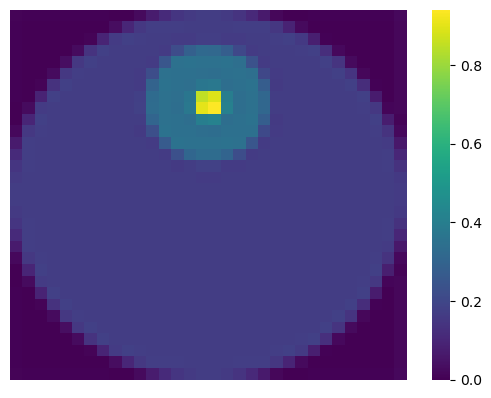

In [5]:
import imageio.v3 as iio
from PIL import Image

im = iio.imread('../data_2/phantom.png')
phantom_img = Image.fromarray(im).resize((32, 32))
phantom_img = np.array(phantom_img.convert('L')) / 255 
# add gaussian noise
# phantom_img = phantom_img + np.random.randn(32, 32) / 25

plot_image(phantom_img)

In [6]:
import json

with open('../data_2/details.json') as file:
    params = json.load(file)
    
params

{'no_of_detectors': 32,
 'source_to_object': 20,
 'source_to_detector': 42,
 'size_of_object': 12,
 'no_of_rotations': 32,
 'fan_beam_angle': 14.67,
 'resolution': 32}

In [7]:
# Theta calculation. MAX CHANCES OF ERROR (unclear info) 
theta_fan = 2 * params['fan_beam_angle']
del params['fan_beam_angle']
params['angle_bw_detectors'] = theta_fan * np.pi / 180 / 31

In [8]:
data = pd.read_csv('../data_2/sinogram.csv', header=None)

In [9]:
d = np.flip(data.to_numpy(), axis=0).flatten()
d.shape

(1024,)

In [10]:
recon = Reconstruction(**params)

Performing decomposition:  96%|█████████▌| 983/1024 [00:51<00:02, 19.12it/s]


Matrix has shape = (1024, 1024)
Matrix has Rank = 983


## Backward Problem

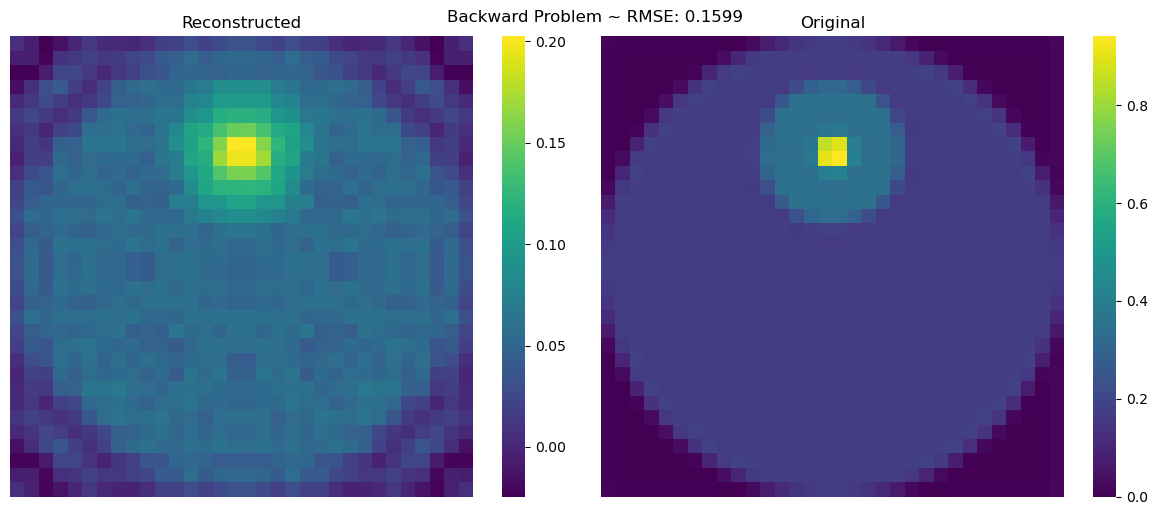

In [11]:
x_img = recon.solve(d)
# plt.imshow(x_img)

plot_images(convolute(x_img), phantom_img, title='Backward Problem ~ ')

## Direct Multiplication Method

In [12]:
x = phantom_img.flatten()
d_recon = recon.A @ x

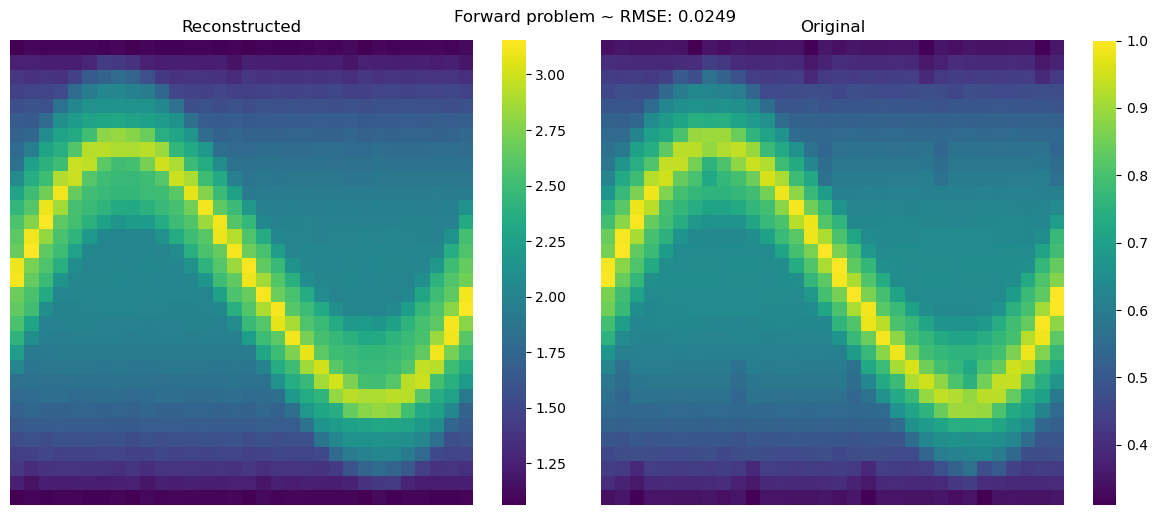

In [13]:
plot_images(d_recon.reshape(32, 32), d.reshape(32, 32), title='Forward problem ~ ');

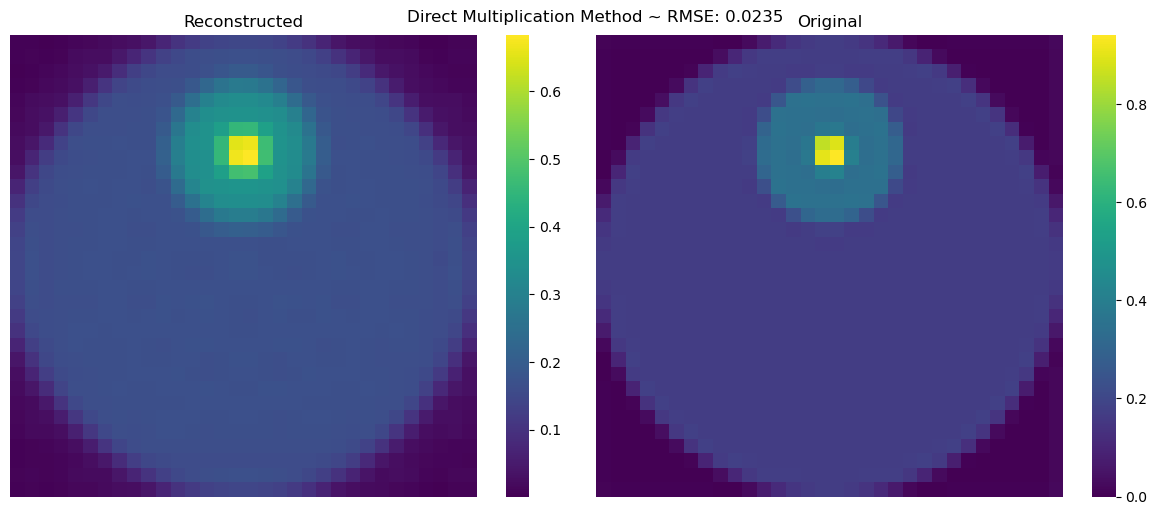

In [14]:
x_recon_img = recon.solve(d_recon)
plot_images(convolute(x_recon_img, 'radial'), phantom_img, rescale_for_rmse=False, title='Direct Multiplication Method ~ ');